# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import datetime
import io
import os
import re
import string
from numpy import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense, Flatten, SimpleRNN, InputLayer, Conv1D, Bidirectional,
                                     GRU, LSTM, BatchNormalization, Dropout, Input, Embedding, TextVectorization)
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
from tensorboard.plugins import projector

Mounted at /content/drive


In [2]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-17 21:03:38--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-17 21:03:38 (76.6 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [3]:
from helper_functions import plot_loss_curves

In [4]:
def plot_loss_curves(history):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['masked_accuracy'])
    val_accuracy = np.array(history.history['val_masked_accuracy'])

    epochs = range(len(history.history['loss']))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

In [5]:
!pip install openpyxl  --quiet

# Data Downloading

In [6]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d shashichander009/inshorts-news-data
! unzip "/content/inshorts-news-data.zip" -d "/content/dataset/"

 72% 9.00M/12.6M [00:00<00:00, 16.7MB/s]
100% 12.6M/12.6M [00:00<00:00, 25.2MB/s]
Archive:  /content/inshorts-news-data.zip
  inflating: /content/dataset/Inshorts Cleaned Data.xlsx  


# Data Loading

In [88]:
df = pd.read_excel("/content/dataset/Inshorts Cleaned Data.xlsx",engine = 'openpyxl')
df.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
df.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [89]:
df.duplicated().sum()

106

In [90]:
df.drop_duplicates(inplace=True)

In [91]:
df.isnull().sum()

Headline    0
Short       0
dtype: int64

In [92]:
df.dropna(inplace=True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54998 entries, 0 to 55103
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  54998 non-null  object
 1   Short     54998 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [94]:
def standardization(input_data):
  input_data = str(input_data)
  no_tag = re.sub(r'<.*?>', '', input_data)
  no_url = re.sub(r'https?://\S+|www\.\S+', '', no_tag)
  return no_url

In [95]:
df['Short'] = df['Short'].apply(standardization)
df['Headline'] = df['Headline'].apply(standardization)

In [96]:
article_sequence_len = [len(sentence.split()) for sentence in df['Short']]
avg_article_sequence_len = np.mean(article_sequence_len)
summary_sequence_len = [len(sentence.split()) for sentence in df['Headline']]
avg_summary_sequence_len = np.mean(summary_sequence_len)

print("Avg Article Sequence Length:", avg_article_sequence_len)
print("Avg Summary Sequence Length:", avg_summary_sequence_len)

Avg Article Sequence Length: 58.18040656023855
Avg Summary Sequence Length: 8.255445652569184


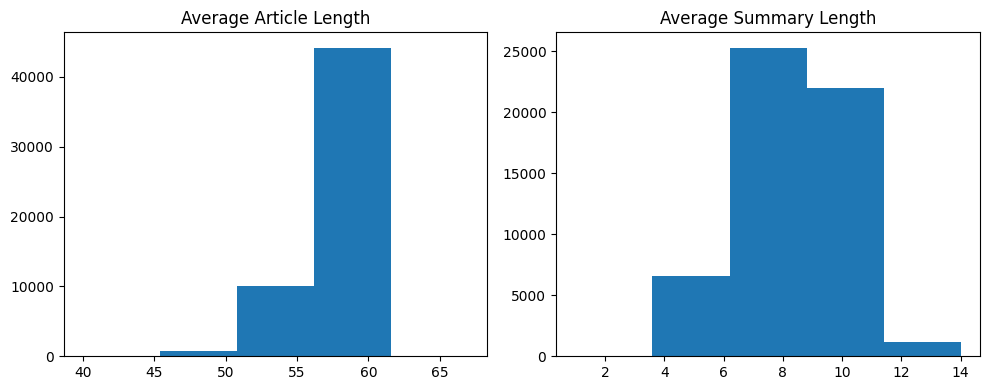

In [97]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Average Article Length")
plt.hist(article_sequence_len, bins=5)

plt.subplot(1, 2, 2)
plt.title("Average Summary Length")
plt.hist(summary_sequence_len, bins=5)

plt.tight_layout()
plt.show()

In [98]:
output_article_sequence_len = int(np.percentile(article_sequence_len, 95))
output_summary_sequence_len = int(np.percentile(summary_sequence_len, 95))
print("Output Article Sequence Length:", output_article_sequence_len)
print("Output summary Sequence Length:", output_summary_sequence_len)

Output Article Sequence Length: 60
Output summary Sequence Length: 11


In [99]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [100]:
train_dataset = tf.data.Dataset.from_tensor_slices((train['Short'], train['Headline']))
test_dataset = tf.data.Dataset.from_tensor_slices((test['Short'], test['Headline']))

In [101]:
vocab_size = 20000
article_sequence_length = 60
summary_sequence_length = 11
embedding_dim = 128
batch_size = 64

In [102]:
article_vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                            max_tokens = None,
                                            output_mode = 'int',
                                            output_sequence_length = article_sequence_length)

In [103]:
sample_summary_vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                                  max_tokens = None,
                                                  output_mode = 'int',
                                                  output_sequence_length = summary_sequence_length)

In [104]:
# article_training_data = train_dataset.map(lambda x, y:x)
article_vectorize_layer.adapt(df['Short'])

In [105]:
article_text_vocab = article_vectorize_layer.get_vocabulary()
print(f"Number of words in vocabulary: {len(article_text_vocab)}"),
print(f"Most common words in the vocabulary: {article_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {article_text_vocab[-5:]}")

Number of words in vocabulary: 125708
Most common words in the vocabulary: ['', '[UNK]', 'the', 'to', 'in']
Least common words in the vocabulary: ['0001', '00000027', '0000000006', '0000000000001', '000000']


In [106]:
# summary_training_data = train_dataset.map(lambda x, y:y)
sample_summary_vectorize_layer.adapt(df['Headline'])

In [107]:
custom_tokens = ['starttoken', 'endtoken']
vocabulary = sample_summary_vectorize_layer.get_vocabulary()
vocabulary_with_custom_tokens = custom_tokens + [token for token in vocabulary if token not in ['', '[UNK]']]

In [108]:
len(vocabulary_with_custom_tokens)

40794

In [109]:
max_tokens = 40794 + 2
summary_vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                            max_tokens = None,
                                            output_mode = 'int',
                                            output_sequence_length = summary_sequence_length)

In [110]:
summary_vectorize_layer.set_vocabulary(vocabulary_with_custom_tokens)

In [111]:
summary_text_vocab = summary_vectorize_layer.get_vocabulary()
print(f"Number of words in vocabulary: {len(summary_text_vocab)}"),
print(f"Most common words in the vocabulary: {summary_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {summary_text_vocab[-5:]}")

Number of words in vocabulary: 40796
Most common words in the vocabulary: ['', '[UNK]', 'starttoken', 'endtoken', 'to']
Least common words in the vocabulary: ['020', '0100kmph', '010', '008', '001s']


In [112]:
article_vectorize_layer.get_config()

{'name': 'text_vectorization_5',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': None,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 60,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 125708}

In [113]:
summary_vectorize_layer.get_config()

{'name': 'text_vectorization_7',
 'trainable': True,
 'dtype': 'string',
 'max_tokens': None,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 11,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 40796}

In [115]:
def selector(inputs, outputs):
  return {'input_1': inputs, 'input_2': 'starttoken ' + outputs}, outputs + ' endtoken'

In [116]:
train_dataset = train_dataset.map(selector)
test_dataset = test_dataset.map(selector)

In [117]:
def vectorizer(inputs, outputs):
  return {'input_1': article_vectorize_layer(inputs['input_1']),
          'input_2': summary_vectorize_layer(inputs['input_2'])}, summary_vectorize_layer(outputs)

In [118]:
train_dataset = train_dataset.map(vectorizer)
test_dataset = test_dataset.map(vectorizer)

In [119]:
for article, summary in train_dataset.take(1):
  print(article)
  print(summary)

{'input_1': <tf.Tensor: shape=(60,), dtype=int64, numpy=
array([    2,   898,  2631,  1386,     5,    34,  3108,     8,    81,
          13,    23,    18,  3519,     3,     2,    43,     3,   531,
          23,  3273,     3,  6960,  5537,     8,   898,  2413,    33,
          99,    26,     2,   289,    74,     8,   173,   447,  2401,
         212,     2,  3108,   340,     3, 18220,     2,  2413,     9,
         980,  6991,  1027,  3108, 18164,  3273,    80,   526,    21,
        3332,     4,     2,  3108,   569,     0])>, 'input_2': <tf.Tensor: shape=(11,), dtype=int64, numpy=
array([    2,  1611,     4,  1110,   125,  4033,     4, 12682,  5726,
           0,     0])>}
tf.Tensor([ 1611     4  1110   125  4033     4 12682  5726     3     0     0], shape=(11,), dtype=int64)


In [120]:
summary_text_vocab[2]

'starttoken'

In [121]:
summary_text_vocab[3]

'endtoken'

In [122]:
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64, drop_remainder=True)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(64, drop_remainder=True)

In [123]:
train_dataset

<_BatchDataset element_spec=({'input_1': TensorSpec(shape=(64, None), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(64, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(64, None), dtype=tf.int64, name=None))>

# Model

In [124]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add

In [137]:
def positional_encoding(model_size, sequence_length):
  output = []
  for pos in range(sequence_length):
    PE = np.zeros((model_size))
    for i in range(model_size):
      if i%2 == 0:
        PE[i] = np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i] = np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE, axis=0))
  out = tf.concat(output, axis=0)
  out = tf.expand_dims(out, axis=0)
  return tf.cast(out, dtype=tf.float32)

In [138]:
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(Layer):
  def __init__(self, vocab_size, d_model, sequence_length):
    super(PositionalEmbedding, self).__init__()
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.token_embeddings = Embedding(input_dim=vocab_size, output_dim=d_model)

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = positional_encoding(self.d_model, self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, *args, **kwargs):
    return self.token_embeddings.compute_mask(*args, **kwargs)

  def get_config(self):
    config = super(PositionalEmbedding, self).get_config()
    config.update({
        'sequence_length': self.sequence_length,
        'vocab_size': self.vocab_size,
        'd_model': self.d_model})
    return config

In [139]:
@tf.keras.utils.register_keras_serializable()
class BaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

In [140]:
@tf.keras.utils.register_keras_serializable()
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [141]:
@tf.keras.utils.register_keras_serializable()
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [142]:
@tf.keras.utils.register_keras_serializable()
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [143]:
@tf.keras.utils.register_keras_serializable()
class FeedForward(Layer):
  def __init__(self, d_model, dff, dropout_rate=0.4):
    super(FeedForward, self).__init__()
    self.d_model = d_model
    self.dff = dff
    self.seq = tf.keras.Sequential([Dense(self.dff, activation='relu'),
                                    Dense(self.d_model),
                                    Dropout(dropout_rate)])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

  def get_config(self):
    config = super(FeedForward, self).get_config()
    config.update({
        'dff_layer': self.dff,
        'd_model': self.d_model})
    return config

In [144]:
@tf.keras.utils.register_keras_serializable()
class EncoderLayer(Layer):
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.4):
    super(EncoderLayer, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.dff = dff
    self.self_attention = GlobalSelfAttention(num_heads=self.num_heads, key_dim=self.d_model, dropout=dropout_rate)
    self.ffn = FeedForward(self.d_model, self.dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

  def get_config(self):
    config = super(EncoderLayer, self).get_config()
    config.update({
        'num_heads': self.num_heads,
        'dff': self.dff,
        'd_model': self.d_model,
    })
    return config

In [145]:
@tf.keras.utils.register_keras_serializable()
class Encoder(Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, sequence_length, dropout_rate=0.4):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.dff = dff
    self.vocab_size = vocab_size
    self.sequence_length = sequence_length
    self.pos_embedding = PositionalEmbedding(vocab_size=self.vocab_size, d_model=self.d_model, sequence_length=self.sequence_length)
    self.enc_layers = [EncoderLayer(d_model=self.d_model, num_heads=self.num_heads, dff=self.dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
    self.dropout = Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x

  def get_config(self):
    config = super(Encoder, self).get_config()
    config.update({
        'num_layers': self.num_layers,
        'd_model': self.d_model,
        'num_heads': self.num_heads,
        'dff': self.dff,
        'vocab_size': self.vocab_size,
        'sequence_length': self.sequence_length,
    })
    return config

In [146]:
@tf.keras.utils.register_keras_serializable()
class DecoderLayer(Layer):
  def __init__(self, d_model, num_heads, dff, dropout_rate=0.4):
    super(DecoderLayer, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.dff = dff
    self.causal_self_attention = CausalSelfAttention(num_heads=self.num_heads, key_dim=self.d_model, dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=self.num_heads, key_dim=self.d_model, dropout=dropout_rate)
    self.ffn = FeedForward(self.d_model, self.dff)

  def call(self, x, context):
    x = self.causal_self_attention(x = x)
    x = self.cross_attention(x = x, context = context)
    x = self.ffn(x)
    return x

  def get_config(self):
    config = super(DecoderLayer, self).get_config()
    config.update({
        'd_model': self.d_model,
        'num_heads': self.num_heads,
        'dff': self.dff,
    })
    return config

In [147]:
@tf.keras.utils.register_keras_serializable()
class Decoder(Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, sequence_length, dropout_rate=0.4):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.dff = dff
    self.vocab_size = vocab_size
    self.sequence_length = sequence_length
    self.pos_embedding = PositionalEmbedding(vocab_size=self.vocab_size, d_model=self.d_model, sequence_length=self.sequence_length)
    self.dropout = Dropout(dropout_rate)
    self.dec_layers = [DecoderLayer(d_model=self.d_model, num_heads=self.num_heads, dff=self.dff, dropout_rate=dropout_rate) for _ in range(self.num_layers)]

  def call(self, x, context):
    x = self.pos_embedding(x)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    return x

  def get_config(self):
    config = super(Decoder, self).get_config()
    config.update({
        'num_layers': self.num_layers,
        'd_model': self.d_model,
        'num_heads': self.num_heads,
        'dff': self.dff,
        'vocab_size': self.vocab_size,
        'sequence_length': self.sequence_length
        })
    return config

In [148]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.4
article_sequence_len = 60
summary_sequence_len = 11
article_vocab_size = 125708
summary_vocab_size = 40796

In [150]:
encoder_inputs = Input(shape=(None,), dtype='int64', name='input_1')
x = Encoder(num_layers=num_layers, d_model=d_model,
            num_heads=num_heads, dff=dff,
            vocab_size = article_vocab_size,
            sequence_length = article_sequence_len,
            dropout_rate=dropout_rate)(encoder_inputs)
encoder_outputs = x

decoder_inputs = Input(shape=(None,), dtype='int64', name='input_2')
x = Decoder(num_layers=num_layers, d_model=d_model,
            num_heads=num_heads, dff=dff,
            vocab_size=summary_vocab_size,
            sequence_length = summary_sequence_len,
            dropout_rate=dropout_rate)(decoder_inputs, encoder_outputs)

decoder_outputs = Dense(summary_vocab_size, activation="softmax")(x)
transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 encoder_3 (Encoder)         (None, 60, 128)              1872947   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 decoder_2 (Decoder)         (None, 11, 128)              9971712   ['input_2[0][0]',   

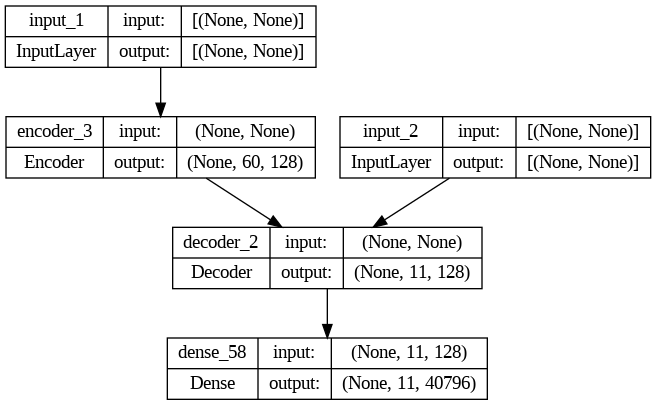

In [151]:
plot_model(transformer, show_shapes=True)

In [152]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

In [153]:
@tf.keras.utils.register_keras_serializable()
class CustomSchedule(LearningRateSchedule):
    def __init__(self, d_model=None, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            'd_model': self.d_model.numpy(),
            'warmup_steps': self.warmup_steps}

In [154]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [155]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred
  mask = label != 0
  match = match & mask
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [156]:
transformer.compile(loss = masked_loss,
                    optimizer = optimizer,
                    metrics = [masked_accuracy])

In [157]:
history = transformer.fit(train_dataset,
                          validation_data = test_dataset,
                          epochs = 5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


687/687 [==============================] - 184s 219ms/step - loss: 8.9171 - masked_accuracy: 0.0980 - val_loss: 7.7740 - val_masked_accuracy: 0.1240
Epoch 2/5
687/687 [==============================] - 107s 155ms/step - loss: 7.5892 - masked_accuracy: 0.1261 - val_loss: 7.6441 - val_masked_accuracy: 0.1293
Epoch 3/5
687/687 [==============================] - 114s 165ms/step - loss: 7.3315 - masked_accuracy: 0.1295 - val_loss: 7.6066 - val_masked_accuracy: 0.1314
Epoch 4/5
687/687 [==============================] - 104s 150ms/step - loss: 7.1735 - masked_accuracy: 0.1325 - val_loss: 7.6734 - val_masked_accuracy: 0.1347
Epoch 5/5
687/687 [==============================] - 103s 150ms/step - loss: 7.0556 - masked_accuracy: 0.1349 - val_loss: 7.6317 - val_masked_accuracy: 0.1340


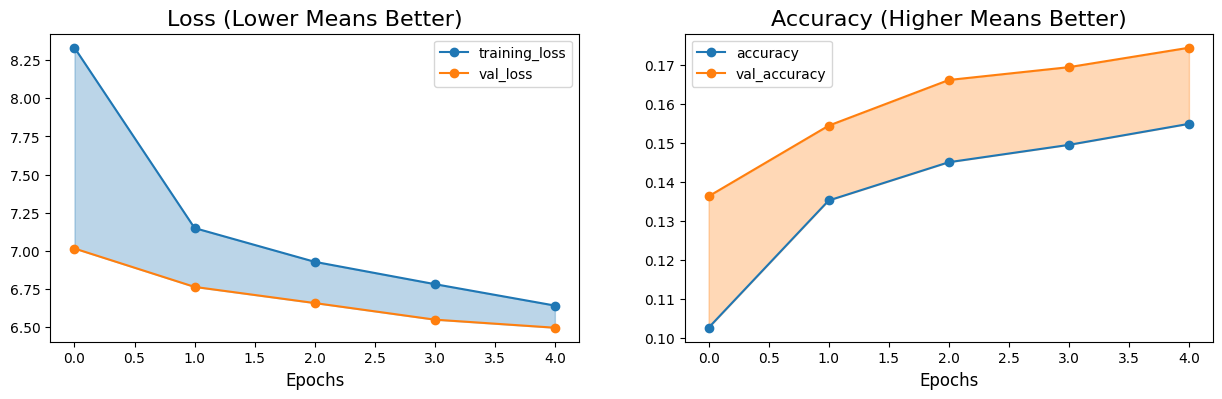

In [62]:
plot_loss_curves(history)

# Saving and Loading Model

In [ ]:
input_article = Input(shape=[1,], dtype='string')
output_layer = article_vectorize_layer(input_article)
article_vectorizer = Model(inputs=input_article, outputs=output_layer)

In [ ]:
article_vectorizer.save("article_vectorizer_model")
loaded_article_vectorizer = tf.keras.models.load_model("article_vectorizer_model")

In [ ]:
input_summary = Input(shape=[1,], dtype='string')
output_layer = summary_vectorize_layer(input_summary)
summary_vectorizer = Model(inputs=input_summary, outputs=output_layer)

In [ ]:
summary_vectorizer.save("summary_vectorizer_model")
loaded_summary_vectorizer = tf.keras.models.load_model("summary_vectorizer_model")

In [ ]:
article_vectorizer.predict(["hello how are you"])

1/1 [==============================] - 0s 53ms/step


array([[13576,   303,    38,   183,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]])

In [ ]:
summary_vectorizer.predict(["hello how are you"])

1/1 [==============================] - 0s 73ms/step


array([[11690,   231,   101,   387,     0,     0,     0,     0,     0,
            0,     0]])

In [ ]:
index_to_word = {x:y for x, y in zip(range(len(summary_vectorize_layer.get_vocabulary())),
                                     summary_vectorize_layer.get_vocabulary())}

In [ ]:
filename = "index_to_word.json"
with open(filename, 'r') as file:
    loaded_index_to_word = json.load(file)

In [ ]:
import json

filename = "index_to_word.json"
with open(filename, 'w') as file:
    json.dump(index_to_word, file)

In [ ]:
transformer.save("transformer_model")

In [ ]:
loaded_transformer = tf.keras.models.load_model("transformer_model", custom_objects={"masked_accuracy": masked_accuracy, "masked_loss": masked_loss})

In [ ]:
%cp -av /content/transformer_model /content/drive/MyDrive/Different_News_Category_Classification

# Model Evaluation

In [ ]:
index_to_word = {x:y for x, y in zip(range(len(summary_vectorize_layer.get_vocabulary())),
                                     summary_vectorize_layer.get_vocabulary())}

In [ ]:
train_data, test_data = train_test_split(test, test_size=0.3)

In [ ]:
! pip install sacrebleu

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import sacrebleu

NLTK_BLEU_SCORE = []
SAC_BLEU_SCORE = []
smoothing = SmoothingFunction()

for article, summary in zip(test_data['Short'], test_data['Headline']):
  tokenized_article_sentence = article_vectorize_layer([article])
  shifted_target = 'starttoken'

  for i in range(11):
    tokenized_shifted_target = summary_vectorize_layer([shifted_target])
    output = transformer.predict([tokenized_article_sentence, tokenized_shifted_target])
    summary_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
    current_word = index_to_word[summary_word_index]
    if current_word == 'endtoken':
      break
    shifted_target += ' ' + current_word
  predicted_sentence = shifted_target[11:]

  bleu_score = sentence_bleu([summary.split()], predicted_sentence.split(), smoothing_function=smoothing.method1)
  NLTK_BLEU_SCORE.append(bleu_score)

  bleu_score = sacrebleu.corpus_bleu([predicted_sentence], [[summary]], force=True)
  SAC_BLEU_SCORE.append(bleu_score.score)

1/1 [==============================] - 0s 70ms/step


KeyboardInterrupt: ignored

In [ ]:
nltk_bleu_score = np.array(NLTK_BLEU_SCORE)
nltk_bleu_score = np.mean(nltk_bleu_score, axis=0)

sac_bleu_scores = np.array(SAC_BLEU_SCORE)
sac_bleu_scores = np.mean(sac_bleu_scores)

print("NLTK Mean BLEU Score:", nltk_bleu_score)
print("SACREBLEU Mean BLEU Score:", sac_bleu_scores)

# Hugging Face Model

In [ ]:
! pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = transformer, repo_id = "DriveMyScream/News_Summarizer_Model")

In [ ]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/News_Summarizer_Model", custom_objects={"masked_accuracy": masked_accuracy, "masked_loss": masked_loss})

In [65]:
index_to_word = {x:y for x, y in zip(range(len(summary_vectorize_layer.get_vocabulary())),
                                     summary_vectorize_layer.get_vocabulary())}

In [158]:
def summarizer(article):
  tokenized_article_sentence = article_vectorize_layer([article])
  shifted_target = 'starttoken'

  for i in range(11):
    tokenized_shifted_target = summary_vectorize_layer([shifted_target])
    output = transformer.predict([tokenized_article_sentence, tokenized_shifted_target])
    summary_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
    current_word = index_to_word[summary_word_index]
    if current_word == 'endtoken':
      break
    shifted_target += ' ' + current_word
  return shifted_target[11:]

In [159]:
summarizer("Before the problems acquire a serious dimension, remember that such problems occur because of exhaustion and lack of oxygen.")

1/1 [==============================] - 0s 29ms/step


'at the the the the the the the the the the'

# Model at inference

In [ ]:
filename = "index_to_word.json"

with open(filename, 'r') as file:
    loaded_index_to_word = json.load(file)

In [ ]:
def summarizer(article):
  tokenized_article_sentence = article_vectorizer.predict([article])
  shifted_target = 'starttoken'

  for i in range(11):
    tokenized_shifted_target = summary_vectorizer.predict([shifted_target])
    output = transformer.predict([tokenized_article_sentence, tokenized_shifted_target])
    summary_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
    current_word = loaded_index_to_word[summary_word_index]
    if current_word == 'endtoken':
      break
    shifted_target += ' ' + current_word
  return shifted_target[11:]

In [ ]:
summarizer("Before the problems acquire a serious dimension, remember that such problems occur because of exhaustion and lack of oxygen.")

1/1 [==============================] - 0s 33ms/step


'lesson browser browser browser ratifies ratifies 50 knee knee knee baroda'

# Tensorflow Lite

In [ ]:
import tensorflow as tf

# path = "/content/transformer_model"
# model = tf.keras.models.load_model(path, custom_objects={"masked_accuracy": masked_accuracy, "masked_loss": masked_loss})

converter = tf.lite.TFLiteConverter.from_keras_model(transformer)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "News_Summarizer_Model.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
model_path = "/content/News_Summarizer_Model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

article_sentence = "Before the problems acquire a serious dimension, remember that such problems occur because of exhaustion and lack of oxygen."
tokenized_article_sentence = article_vectorize_layer([article_sentence])
shifted_target = 'starttoken'
max_sequence_length = 11

for i in range(max_sequence_length):
    tokenized_shifted_target = summary_vectorize_layer([shifted_target])
    interpreter.set_tensor(input_details[0]['index'], tokenized_article_sentence)
    interpreter.set_tensor(input_details[1]['index'], tokenized_shifted_target)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    summary_word_index = tf.argmax(output_data, axis=-1)[0][i].numpy()
    current_word = index_to_word[summary_word_index]
    if current_word == 'endtoken':
        break
    shifted_target += ' ' + current_word

summary_sentence = shifted_target[11:]
print(summary_sentence)